In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [3]:
data_df = pd.read_csv('../../_data/Kr2010.csv', index_col=0)

min_rt = data_df.groupby(by='sbj')['rt'].min()

tr_df, ts_df = data_df.copy(), data_df.copy()

obs_train = np.asarray(data_df[['rt', 'Right']])
X_train = np.asarray(data_df[['item_value_1', 'item_value_2', 'gaze_1', 'gaze_2']])

obs_test = np.asarray(data_df[['rt', 'Right']])
X_test = np.asarray(data_df[['item_value_1', 'item_value_2', 'gaze_1', 'gaze_2']])

print(X_train.shape, X_test.shape)

(3522, 4) (3522, 4)


In [4]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):
    ndt = tf.convert_to_tensor([min_rt[i]*tf.math.sigmoid(model.layers[-1].weights[-1][i-1]) for i in tr_df['sbj']])
    thr = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-2][i-1])) for i in tr_df['sbj']])
    scl = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-3][i-1])) for i in tr_df['sbj']])
    
    ll1 = (1 - obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]))
    
    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2), axis=-1)

In [5]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [6]:
layers_neuron = [10, 10, 8, 5]
input_shape = 4
output_shape = 2
activation = 'tanh'
n_sbj = data_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 out_layer (Out_layer)       (None, 2)                 129       
                                                                 
Total params: 422 (1.65 KB)
Trainable params: 422 (1.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [7]:
history = model.fit(X_train, obs_train, shuffle=False, batch_size=X_train.shape[0], epochs=4000)

Epoch 1/4000
1/1 [==============================] - 90s 90s/step - loss: 21319.6387
Epoch 2/4000
1/1 [==============================] - 0s 32ms/step - loss: 21227.1602
Epoch 3/4000
1/1 [==============================] - 0s 22ms/step - loss: 21161.5078
Epoch 4/4000
1/1 [==============================] - 0s 22ms/step - loss: 21106.6680
Epoch 5/4000
1/1 [==============================] - 0s 24ms/step - loss: 21058.1660
Epoch 6/4000
1/1 [==============================] - 0s 22ms/step - loss: 21013.8984
Epoch 7/4000
1/1 [==============================] - 0s 22ms/step - loss: 20972.6914
Epoch 8/4000
1/1 [==============================] - 0s 21ms/step - loss: 20933.7793
Epoch 9/4000
1/1 [==============================] - 0s 21ms/step - loss: 20896.6562
Epoch 10/4000
1/1 [==============================] - 0s 25ms/step - loss: 20860.9473
Epoch 11/4000
1/1 [==============================] - 0s 22ms/step - loss: 20826.3594
Epoch 12/4000
1/1 [==============================] - 0s 22ms/step - loss: 

1/1 [==============================] - 0s 32ms/step - loss: 17291.5527
Epoch 193/4000
1/1 [==============================] - 0s 32ms/step - loss: 17280.0762
Epoch 194/4000
1/1 [==============================] - 0s 32ms/step - loss: 17268.6426
Epoch 195/4000
1/1 [==============================] - 0s 32ms/step - loss: 17257.2500
Epoch 196/4000
1/1 [==============================] - 0s 32ms/step - loss: 17245.8945
Epoch 197/4000
1/1 [==============================] - 0s 33ms/step - loss: 17234.5840
Epoch 198/4000
1/1 [==============================] - 0s 32ms/step - loss: 17223.3086
Epoch 199/4000
1/1 [==============================] - 0s 32ms/step - loss: 17212.0703
Epoch 200/4000
1/1 [==============================] - 0s 32ms/step - loss: 17200.8711
Epoch 201/4000
1/1 [==============================] - 0s 33ms/step - loss: 17189.7031
Epoch 202/4000
1/1 [==============================] - 0s 32ms/step - loss: 17178.5684
Epoch 203/4000
1/1 [==============================] - 0s 33ms/step - 

1/1 [==============================] - 0s 33ms/step - loss: 15210.4697
Epoch 383/4000
1/1 [==============================] - 0s 32ms/step - loss: 15198.8496
Epoch 384/4000
1/1 [==============================] - 0s 33ms/step - loss: 15187.2520
Epoch 385/4000
1/1 [==============================] - 0s 33ms/step - loss: 15175.6807
Epoch 386/4000
1/1 [==============================] - 0s 33ms/step - loss: 15164.1309
Epoch 387/4000
1/1 [==============================] - 0s 33ms/step - loss: 15152.6074
Epoch 388/4000
1/1 [==============================] - 0s 33ms/step - loss: 15141.1084
Epoch 389/4000
1/1 [==============================] - 0s 33ms/step - loss: 15129.6318
Epoch 390/4000
1/1 [==============================] - 0s 32ms/step - loss: 15118.1816
Epoch 391/4000
1/1 [==============================] - 0s 33ms/step - loss: 15106.7578
Epoch 392/4000
1/1 [==============================] - 0s 33ms/step - loss: 15095.3545
Epoch 393/4000
1/1 [==============================] - 0s 32ms/step - 

1/1 [==============================] - 0s 49ms/step - loss: 13377.6523
Epoch 573/4000
1/1 [==============================] - 0s 49ms/step - loss: 13369.5840
Epoch 574/4000
1/1 [==============================] - 0s 46ms/step - loss: 13361.5146
Epoch 575/4000
1/1 [==============================] - 0s 39ms/step - loss: 13353.4863
Epoch 576/4000
1/1 [==============================] - 0s 36ms/step - loss: 13345.4678
Epoch 577/4000
1/1 [==============================] - 0s 37ms/step - loss: 13337.4922
Epoch 578/4000
1/1 [==============================] - 0s 37ms/step - loss: 13329.5146
Epoch 579/4000
1/1 [==============================] - 0s 41ms/step - loss: 13321.5566
Epoch 580/4000
1/1 [==============================] - 0s 37ms/step - loss: 13313.5742
Epoch 581/4000
1/1 [==============================] - 0s 40ms/step - loss: 13305.6025
Epoch 582/4000
1/1 [==============================] - 0s 39ms/step - loss: 13297.6299
Epoch 583/4000
1/1 [==============================] - 0s 39ms/step - 

1/1 [==============================] - 0s 34ms/step - loss: 12059.1152
Epoch 763/4000
1/1 [==============================] - 0s 35ms/step - loss: 12053.2852
Epoch 764/4000
1/1 [==============================] - 0s 35ms/step - loss: 12047.4521
Epoch 765/4000
1/1 [==============================] - 0s 35ms/step - loss: 12041.6523
Epoch 766/4000
1/1 [==============================] - 0s 33ms/step - loss: 12035.7070
Epoch 767/4000
1/1 [==============================] - 0s 34ms/step - loss: 12029.8008
Epoch 768/4000
1/1 [==============================] - 0s 35ms/step - loss: 12023.8447
Epoch 769/4000
1/1 [==============================] - 0s 37ms/step - loss: 12017.9922
Epoch 770/4000
1/1 [==============================] - 0s 39ms/step - loss: 12012.1650
Epoch 771/4000
1/1 [==============================] - 0s 36ms/step - loss: 12006.4258
Epoch 772/4000
1/1 [==============================] - 0s 35ms/step - loss: 12000.6807
Epoch 773/4000
1/1 [==============================] - 0s 34ms/step - 

1/1 [==============================] - 0s 35ms/step - loss: 11090.9473
Epoch 953/4000
1/1 [==============================] - 0s 34ms/step - loss: 11086.6533
Epoch 954/4000
1/1 [==============================] - 0s 36ms/step - loss: 11082.3418
Epoch 955/4000
1/1 [==============================] - 0s 36ms/step - loss: 11078.0498
Epoch 956/4000
1/1 [==============================] - 0s 36ms/step - loss: 11073.7451
Epoch 957/4000
1/1 [==============================] - 0s 36ms/step - loss: 11069.4834
Epoch 958/4000
1/1 [==============================] - 0s 35ms/step - loss: 11065.2070
Epoch 959/4000
1/1 [==============================] - 0s 43ms/step - loss: 11060.9824
Epoch 960/4000
1/1 [==============================] - 0s 55ms/step - loss: 11056.7197
Epoch 961/4000
1/1 [==============================] - 0s 38ms/step - loss: 11052.5127
Epoch 962/4000
1/1 [==============================] - 0s 35ms/step - loss: 11048.2480
Epoch 963/4000
1/1 [==============================] - 0s 35ms/step - 

1/1 [==============================] - 0s 33ms/step - loss: 10424.8076
Epoch 1141/4000
1/1 [==============================] - 0s 33ms/step - loss: 10422.1865
Epoch 1142/4000
1/1 [==============================] - 0s 33ms/step - loss: 10419.6523
Epoch 1143/4000
1/1 [==============================] - 0s 33ms/step - loss: 10416.9629
Epoch 1144/4000
1/1 [==============================] - 0s 34ms/step - loss: 10414.2764
Epoch 1145/4000
1/1 [==============================] - 0s 34ms/step - loss: 10411.3672
Epoch 1146/4000
1/1 [==============================] - 0s 33ms/step - loss: 10408.5723
Epoch 1147/4000
1/1 [==============================] - 0s 34ms/step - loss: 10405.7285
Epoch 1148/4000
1/1 [==============================] - 0s 34ms/step - loss: 10403.0322
Epoch 1149/4000
1/1 [==============================] - 0s 33ms/step - loss: 10400.3877
Epoch 1150/4000
1/1 [==============================] - 0s 34ms/step - loss: 10397.9189
Epoch 1151/4000
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 33ms/step - loss: 10047.5488
Epoch 1329/4000
1/1 [==============================] - 0s 33ms/step - loss: 10045.8896
Epoch 1330/4000
1/1 [==============================] - 0s 33ms/step - loss: 10044.4434
Epoch 1331/4000
1/1 [==============================] - 0s 34ms/step - loss: 10042.9600
Epoch 1332/4000
1/1 [==============================] - 0s 32ms/step - loss: 10041.6738
Epoch 1333/4000
1/1 [==============================] - 0s 33ms/step - loss: 10040.5000
Epoch 1334/4000
1/1 [==============================] - 0s 32ms/step - loss: 10039.7686
Epoch 1335/4000
1/1 [==============================] - 0s 33ms/step - loss: 10039.5117
Epoch 1336/4000
1/1 [==============================] - 0s 33ms/step - loss: 10038.4473
Epoch 1337/4000
1/1 [==============================] - 0s 33ms/step - loss: 10036.5342
Epoch 1338/4000
1/1 [==============================] - 0s 33ms/step - loss: 10034.1650
Epoch 1339/4000
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 32ms/step - loss: 9939.2451
Epoch 1424/4000
1/1 [==============================] - 0s 32ms/step - loss: 9936.2236
Epoch 1425/4000
1/1 [==============================] - 0s 32ms/step - loss: 9934.2646
Epoch 1426/4000
1/1 [==============================] - 0s 32ms/step - loss: 9932.7861
Epoch 1427/4000
1/1 [==============================] - 0s 33ms/step - loss: 9931.6094
Epoch 1428/4000
1/1 [==============================] - 0s 32ms/step - loss: 9930.6602
Epoch 1429/4000
1/1 [==============================] - 0s 32ms/step - loss: 9929.7588
Epoch 1430/4000
1/1 [==============================] - 0s 32ms/step - loss: 9929.1650
Epoch 1431/4000
1/1 [==============================] - 0s 32ms/step - loss: 9928.7041
Epoch 1432/4000
1/1 [==============================] - 0s 32ms/step - loss: 9928.4277
Epoch 1433/4000
1/1 [==============================] - 0s 32ms/step - loss: 9927.5342
Epoch 1434/4000
1/1 [==============================] - 0s 32ms/step - 

1/1 [==============================] - 0s 33ms/step - loss: 9790.9102
Epoch 1614/4000
1/1 [==============================] - 0s 33ms/step - loss: 9790.3525
Epoch 1615/4000
1/1 [==============================] - 0s 34ms/step - loss: 9790.0059
Epoch 1616/4000
1/1 [==============================] - 0s 33ms/step - loss: 9790.0127
Epoch 1617/4000
1/1 [==============================] - 0s 32ms/step - loss: 9790.6035
Epoch 1618/4000
1/1 [==============================] - 0s 32ms/step - loss: 9792.1475
Epoch 1619/4000
1/1 [==============================] - 0s 32ms/step - loss: 9793.1357
Epoch 1620/4000
1/1 [==============================] - 0s 32ms/step - loss: 9790.5674
Epoch 1621/4000
1/1 [==============================] - 0s 32ms/step - loss: 9788.3369
Epoch 1622/4000
1/1 [==============================] - 0s 33ms/step - loss: 9786.3691
Epoch 1623/4000
1/1 [==============================] - 0s 33ms/step - loss: 9785.0723
Epoch 1624/4000
1/1 [==============================] - 0s 33ms/step - 

1/1 [==============================] - 0s 32ms/step - loss: 9708.7920
Epoch 1804/4000
1/1 [==============================] - 0s 33ms/step - loss: 9698.2236
Epoch 1805/4000
1/1 [==============================] - 0s 33ms/step - loss: 9696.1689
Epoch 1806/4000
1/1 [==============================] - 0s 32ms/step - loss: 9695.2920
Epoch 1807/4000
1/1 [==============================] - 0s 32ms/step - loss: 9694.7852
Epoch 1808/4000
1/1 [==============================] - 0s 33ms/step - loss: 9694.6875
Epoch 1809/4000
1/1 [==============================] - 0s 32ms/step - loss: 9694.0146
Epoch 1810/4000
1/1 [==============================] - 0s 33ms/step - loss: 9692.7568
Epoch 1811/4000
1/1 [==============================] - 0s 33ms/step - loss: 9694.5518
Epoch 1812/4000
1/1 [==============================] - 0s 32ms/step - loss: 9693.5244
Epoch 1813/4000
1/1 [==============================] - 0s 33ms/step - loss: 9692.9141
Epoch 1814/4000
1/1 [==============================] - 0s 32ms/step - 

1/1 [==============================] - 0s 32ms/step - loss: 9631.7578
Epoch 1994/4000
1/1 [==============================] - 0s 32ms/step - loss: 9631.8691
Epoch 1995/4000
1/1 [==============================] - 0s 33ms/step - loss: 9628.9150
Epoch 1996/4000
1/1 [==============================] - 0s 33ms/step - loss: 9629.9561
Epoch 1997/4000
1/1 [==============================] - 0s 33ms/step - loss: 9631.0859
Epoch 1998/4000
1/1 [==============================] - 0s 33ms/step - loss: 9632.0010
Epoch 1999/4000
1/1 [==============================] - 0s 33ms/step - loss: 9631.2256
Epoch 2000/4000
1/1 [==============================] - 0s 33ms/step - loss: 9635.5420
Epoch 2001/4000
1/1 [==============================] - 0s 33ms/step - loss: 9638.3965
Epoch 2002/4000
1/1 [==============================] - 0s 33ms/step - loss: 9635.4775
Epoch 2003/4000
1/1 [==============================] - 0s 33ms/step - loss: 9632.8203
Epoch 2004/4000
1/1 [==============================] - 0s 32ms/step - 

1/1 [==============================] - 0s 34ms/step - loss: 9585.2354
Epoch 2184/4000
1/1 [==============================] - 0s 33ms/step - loss: 9585.3213
Epoch 2185/4000
1/1 [==============================] - 0s 34ms/step - loss: 9585.1641
Epoch 2186/4000
1/1 [==============================] - 0s 34ms/step - loss: 9584.4766
Epoch 2187/4000
1/1 [==============================] - 0s 33ms/step - loss: 9582.0068
Epoch 2188/4000
1/1 [==============================] - 0s 34ms/step - loss: 9582.5635
Epoch 2189/4000
1/1 [==============================] - 0s 34ms/step - loss: 9583.0742
Epoch 2190/4000
1/1 [==============================] - 0s 33ms/step - loss: 9582.3818
Epoch 2191/4000
1/1 [==============================] - 0s 33ms/step - loss: 9582.9541
Epoch 2192/4000
1/1 [==============================] - 0s 33ms/step - loss: 9582.4443
Epoch 2193/4000
1/1 [==============================] - 0s 33ms/step - loss: 9583.2500
Epoch 2194/4000
1/1 [==============================] - 0s 34ms/step - 

1/1 [==============================] - 0s 36ms/step - loss: 9543.8203
Epoch 2374/4000
1/1 [==============================] - 0s 37ms/step - loss: 9546.8311
Epoch 2375/4000
1/1 [==============================] - 0s 36ms/step - loss: 9547.4873
Epoch 2376/4000
1/1 [==============================] - 0s 36ms/step - loss: 9545.5566
Epoch 2377/4000
1/1 [==============================] - 0s 37ms/step - loss: 9545.3105
Epoch 2378/4000
1/1 [==============================] - 0s 36ms/step - loss: 9542.1992
Epoch 2379/4000
1/1 [==============================] - 0s 38ms/step - loss: 9548.3213
Epoch 2380/4000
1/1 [==============================] - 0s 39ms/step - loss: 9559.1240
Epoch 2381/4000
1/1 [==============================] - 0s 38ms/step - loss: 9549.3584
Epoch 2382/4000
1/1 [==============================] - 0s 36ms/step - loss: 9545.9189
Epoch 2383/4000
1/1 [==============================] - 0s 37ms/step - loss: 9542.5840
Epoch 2384/4000
1/1 [==============================] - 0s 37ms/step - 

1/1 [==============================] - 0s 33ms/step - loss: 9517.1084
Epoch 2564/4000
1/1 [==============================] - 0s 33ms/step - loss: 9516.1475
Epoch 2565/4000
1/1 [==============================] - 0s 32ms/step - loss: 9517.5771
Epoch 2566/4000
1/1 [==============================] - 0s 33ms/step - loss: 9517.9658
Epoch 2567/4000
1/1 [==============================] - 0s 32ms/step - loss: 9514.2109
Epoch 2568/4000
1/1 [==============================] - 0s 33ms/step - loss: 9514.9746
Epoch 2569/4000
1/1 [==============================] - 0s 33ms/step - loss: 9514.7705
Epoch 2570/4000
1/1 [==============================] - 0s 33ms/step - loss: 9515.2188
Epoch 2571/4000
1/1 [==============================] - 0s 33ms/step - loss: 9516.5420
Epoch 2572/4000
1/1 [==============================] - 0s 33ms/step - loss: 9522.4824
Epoch 2573/4000
1/1 [==============================] - 0s 33ms/step - loss: 9550.9180
Epoch 2574/4000
1/1 [==============================] - 0s 34ms/step - 

1/1 [==============================] - 0s 42ms/step - loss: 9546.4678
Epoch 2660/4000
1/1 [==============================] - 0s 36ms/step - loss: 9504.6201
Epoch 2661/4000
1/1 [==============================] - 0s 37ms/step - loss: nan
Epoch 2662/4000
1/1 [==============================] - 0s 37ms/step - loss: 9501.3994
Epoch 2663/4000
1/1 [==============================] - 0s 35ms/step - loss: 9500.6514
Epoch 2664/4000
1/1 [==============================] - 0s 35ms/step - loss: 9503.4053
Epoch 2665/4000
1/1 [==============================] - 0s 36ms/step - loss: 9503.3779
Epoch 2666/4000
1/1 [==============================] - 0s 36ms/step - loss: 9504.5127
Epoch 2667/4000
1/1 [==============================] - 0s 35ms/step - loss: 9503.3936
Epoch 2668/4000
1/1 [==============================] - 0s 35ms/step - loss: 9500.9404
Epoch 2669/4000
1/1 [==============================] - 0s 35ms/step - loss: 9505.6387
Epoch 2670/4000
1/1 [==============================] - 0s 36ms/step - loss: 

1/1 [==============================] - 0s 35ms/step - loss: 9485.8848
Epoch 2850/4000
1/1 [==============================] - 0s 35ms/step - loss: 9486.6152
Epoch 2851/4000
1/1 [==============================] - 0s 34ms/step - loss: 9490.9932
Epoch 2852/4000
1/1 [==============================] - 0s 34ms/step - loss: 9486.7275
Epoch 2853/4000
1/1 [==============================] - 0s 34ms/step - loss: 9484.0723
Epoch 2854/4000
1/1 [==============================] - 0s 36ms/step - loss: 9482.7861
Epoch 2855/4000
1/1 [==============================] - 0s 34ms/step - loss: 9482.2588
Epoch 2856/4000
1/1 [==============================] - 0s 34ms/step - loss: 9482.6338
Epoch 2857/4000
1/1 [==============================] - 0s 33ms/step - loss: 9483.5713
Epoch 2858/4000
1/1 [==============================] - 0s 33ms/step - loss: 9482.1348
Epoch 2859/4000
1/1 [==============================] - 0s 33ms/step - loss: 9482.8320
Epoch 2860/4000
1/1 [==============================] - 0s 34ms/step - 

1/1 [==============================] - 0s 33ms/step - loss: 9463.6299
Epoch 3040/4000
1/1 [==============================] - 0s 34ms/step - loss: 9465.1475
Epoch 3041/4000
1/1 [==============================] - 0s 34ms/step - loss: 9463.1445
Epoch 3042/4000
1/1 [==============================] - 0s 33ms/step - loss: 9462.7637
Epoch 3043/4000
1/1 [==============================] - 0s 34ms/step - loss: 9462.2920
Epoch 3044/4000
1/1 [==============================] - 0s 34ms/step - loss: 9463.8193
Epoch 3045/4000
1/1 [==============================] - 0s 34ms/step - loss: 9462.3623
Epoch 3046/4000
1/1 [==============================] - 0s 33ms/step - loss: 9461.9082
Epoch 3047/4000
1/1 [==============================] - 0s 33ms/step - loss: 9462.3857
Epoch 3048/4000
1/1 [==============================] - 0s 34ms/step - loss: 9462.2773
Epoch 3049/4000
1/1 [==============================] - 0s 33ms/step - loss: 9462.7988
Epoch 3050/4000
1/1 [==============================] - 0s 34ms/step - 

Epoch 3135/4000
1/1 [==============================] - 0s 33ms/step - loss: 9455.4258
Epoch 3136/4000
1/1 [==============================] - 0s 33ms/step - loss: 9455.6299
Epoch 3137/4000
1/1 [==============================] - 0s 33ms/step - loss: 9461.4385
Epoch 3138/4000
1/1 [==============================] - 0s 33ms/step - loss: 9458.8135
Epoch 3139/4000
1/1 [==============================] - 0s 33ms/step - loss: 9462.7061
Epoch 3140/4000
1/1 [==============================] - 0s 34ms/step - loss: 9458.9766
Epoch 3141/4000
1/1 [==============================] - 0s 34ms/step - loss: 9458.5811
Epoch 3142/4000
1/1 [==============================] - 0s 33ms/step - loss: 9456.7363
Epoch 3143/4000
1/1 [==============================] - 0s 35ms/step - loss: 9458.8916
Epoch 3144/4000
1/1 [==============================] - 0s 35ms/step - loss: 9459.2197
Epoch 3145/4000
1/1 [==============================] - 0s 34ms/step - loss: 9458.6748
Epoch 3146/4000
1/1 [==============================] -

1/1 [==============================] - 0s 35ms/step - loss: 9446.6572
Epoch 3326/4000
1/1 [==============================] - 0s 33ms/step - loss: 9440.2314
Epoch 3327/4000
1/1 [==============================] - 0s 33ms/step - loss: 9439.5508
Epoch 3328/4000
1/1 [==============================] - 0s 34ms/step - loss: 9441.3252
Epoch 3329/4000
1/1 [==============================] - 0s 33ms/step - loss: 9440.8389
Epoch 3330/4000
1/1 [==============================] - 0s 34ms/step - loss: 9441.1943
Epoch 3331/4000
1/1 [==============================] - 0s 33ms/step - loss: 9441.8174
Epoch 3332/4000
1/1 [==============================] - 0s 34ms/step - loss: 9443.3818
Epoch 3333/4000
1/1 [==============================] - 0s 34ms/step - loss: 9445.1523
Epoch 3334/4000
1/1 [==============================] - 0s 33ms/step - loss: 9451.2236
Epoch 3335/4000
1/1 [==============================] - 0s 33ms/step - loss: 9455.6484
Epoch 3336/4000
1/1 [==============================] - 0s 33ms/step - 

1/1 [==============================] - 0s 34ms/step - loss: 9430.6318
Epoch 3422/4000
1/1 [==============================] - 0s 34ms/step - loss: 9431.7324
Epoch 3423/4000
1/1 [==============================] - 0s 33ms/step - loss: 9431.7666
Epoch 3424/4000
1/1 [==============================] - 0s 34ms/step - loss: 9431.9336
Epoch 3425/4000
1/1 [==============================] - 0s 33ms/step - loss: 9431.1514
Epoch 3426/4000
1/1 [==============================] - 0s 34ms/step - loss: 9430.9492
Epoch 3427/4000
1/1 [==============================] - 0s 33ms/step - loss: 9431.0947
Epoch 3428/4000
1/1 [==============================] - 0s 34ms/step - loss: 9430.7656
Epoch 3429/4000
1/1 [==============================] - 0s 35ms/step - loss: 9432.6211
Epoch 3430/4000
1/1 [==============================] - 0s 34ms/step - loss: 9432.7070
Epoch 3431/4000
1/1 [==============================] - 0s 34ms/step - loss: 9434.2451
Epoch 3432/4000
1/1 [==============================] - 0s 35ms/step - 

Epoch 3517/4000
1/1 [==============================] - 0s 34ms/step - loss: 9428.5635
Epoch 3518/4000
1/1 [==============================] - 0s 34ms/step - loss: 9427.7793
Epoch 3519/4000
1/1 [==============================] - 0s 33ms/step - loss: 9430.6943
Epoch 3520/4000
1/1 [==============================] - 0s 33ms/step - loss: 9428.7598
Epoch 3521/4000
1/1 [==============================] - 0s 33ms/step - loss: 9432.3799
Epoch 3522/4000
1/1 [==============================] - 0s 34ms/step - loss: 9431.4248
Epoch 3523/4000
1/1 [==============================] - 0s 33ms/step - loss: 9426.9170
Epoch 3524/4000
1/1 [==============================] - 0s 33ms/step - loss: nan
Epoch 3525/4000
1/1 [==============================] - 0s 33ms/step - loss: 9429.8486
Epoch 3526/4000
1/1 [==============================] - 0s 34ms/step - loss: 9427.5127
Epoch 3527/4000
1/1 [==============================] - 0s 33ms/step - loss: 9428.2246
Epoch 3528/4000
1/1 [==============================] - 0s 34

1/1 [==============================] - 0s 33ms/step - loss: 9423.3994
Epoch 3614/4000
1/1 [==============================] - 0s 34ms/step - loss: 9427.6152
Epoch 3615/4000
1/1 [==============================] - 0s 33ms/step - loss: 9427.9932
Epoch 3616/4000
1/1 [==============================] - 0s 33ms/step - loss: 9432.0967
Epoch 3617/4000
1/1 [==============================] - 0s 33ms/step - loss: nan
Epoch 3618/4000
1/1 [==============================] - 0s 33ms/step - loss: 9424.0576
Epoch 3619/4000
1/1 [==============================] - 0s 33ms/step - loss: 9430.5557
Epoch 3620/4000
1/1 [==============================] - 0s 34ms/step - loss: 9422.0264
Epoch 3621/4000
1/1 [==============================] - 0s 33ms/step - loss: 9428.7803
Epoch 3622/4000
1/1 [==============================] - 0s 33ms/step - loss: 9498.8652
Epoch 3623/4000
1/1 [==============================] - 0s 34ms/step - loss: 9432.7168
Epoch 3624/4000
1/1 [==============================] - 0s 34ms/step - loss: 

1/1 [==============================] - 0s 34ms/step - loss: 9420.4463
Epoch 3805/4000
1/1 [==============================] - 0s 34ms/step - loss: 9416.3760
Epoch 3806/4000
1/1 [==============================] - 0s 33ms/step - loss: 9416.9111
Epoch 3807/4000
1/1 [==============================] - 0s 33ms/step - loss: 9412.1621
Epoch 3808/4000
1/1 [==============================] - 0s 33ms/step - loss: 9413.7812
Epoch 3809/4000
1/1 [==============================] - 0s 33ms/step - loss: 9412.7920
Epoch 3810/4000
1/1 [==============================] - 0s 33ms/step - loss: 9413.6523
Epoch 3811/4000
1/1 [==============================] - 0s 34ms/step - loss: 9414.5635
Epoch 3812/4000
1/1 [==============================] - 0s 33ms/step - loss: 9415.1777
Epoch 3813/4000
1/1 [==============================] - 0s 33ms/step - loss: 9412.9248
Epoch 3814/4000
1/1 [==============================] - 0s 33ms/step - loss: nan
Epoch 3815/4000
1/1 [==============================] - 0s 33ms/step - loss: 

1/1 [==============================] - 0s 33ms/step - loss: 9410.8809
Epoch 3901/4000
1/1 [==============================] - 0s 34ms/step - loss: 9409.4336
Epoch 3902/4000
1/1 [==============================] - 0s 34ms/step - loss: 9410.5186
Epoch 3903/4000
1/1 [==============================] - 0s 33ms/step - loss: 9406.7744
Epoch 3904/4000
1/1 [==============================] - 0s 34ms/step - loss: 9408.3154
Epoch 3905/4000
1/1 [==============================] - 0s 36ms/step - loss: nan
Epoch 3906/4000
1/1 [==============================] - 0s 34ms/step - loss: 9440.2793
Epoch 3907/4000
1/1 [==============================] - 0s 34ms/step - loss: 9421.1855
Epoch 3908/4000
1/1 [==============================] - 0s 34ms/step - loss: 9415.9922
Epoch 3909/4000
1/1 [==============================] - 0s 34ms/step - loss: 9410.1553
Epoch 3910/4000
1/1 [==============================] - 0s 33ms/step - loss: 9410.8389
Epoch 3911/4000
1/1 [==============================] - 0s 33ms/step - loss: 

Epoch 3996/4000
1/1 [==============================] - 0s 34ms/step - loss: 9404.7168
Epoch 3997/4000
1/1 [==============================] - 0s 35ms/step - loss: 9402.2168
Epoch 3998/4000
1/1 [==============================] - 0s 34ms/step - loss: 9401.3701
Epoch 3999/4000
1/1 [==============================] - 0s 33ms/step - loss: 9403.2588
Epoch 4000/4000
1/1 [==============================] - 0s 34ms/step - loss: 9399.9434


In [8]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

111/111 [==============================] - 0s 312us/step


In [9]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'val1': [],
            'val2':[],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['val1'].append(ts_df.item_value_1[s])
        pred_bhv['val2'].append(ts_df.item_value_2[s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

In [10]:
pred_bhv['diff'] = pred_bhv['val2'] - pred_bhv['val1']

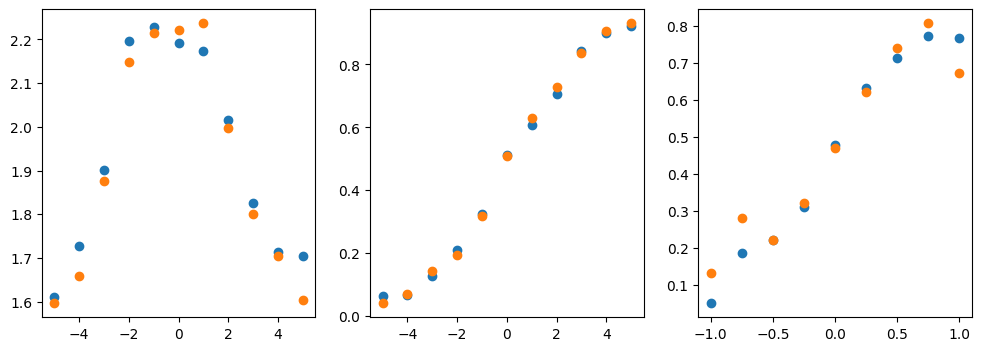

In [25]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(x=pred_bhv.groupby(by='diff')['diff'].mean(), y=pred_bhv.groupby(by='diff')['rt'].mean());
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['rt'].mean());

plt.subplot(132)
plt.scatter(x=pred_bhv.groupby(by='diff')['diff'].mean(), y=pred_bhv.groupby(by='diff')['ch'].mean());
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['choice'].mean()-1);

plt.subplot(133)
plt.scatter(x=pred_bhv.groupby(by='gaze_diff')['gaze_diff'].mean(), y=pred_bhv.groupby(by='gaze_diff')['ch'].mean());
plt.scatter(x=ts_df.groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df.groupby(by='Dwell Time Advantage (R - L)')['choice'].mean()-1);

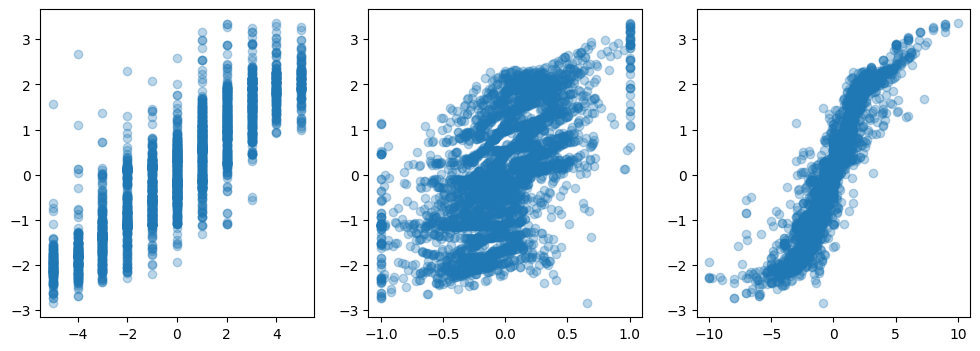

In [24]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 0] - X_test[:, 1], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.3);

plt.subplot(132)
plt.scatter(X_test[:, 2] - X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.3);

plt.subplot(133)
plt.scatter(X_test[:, 0]*X_test[:, 2] - X_test[:, 1]*X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.3);